# **Chess Piece Classification using Convolutional Neural Networks in PyTorch**
This notebook demonstrates how to build and train a convolutional neural network (CNN) for classifying chess pieces using FEN notation from grayscale image tiles (32x32). It includes custom dataset handling, preprocessing of FEN (Forsyth-Edwards Notation) strings, and training the model on chess images. The model is trained on a PyTorch-based architecture, with support for CUDA and CPU. The notebook also features misclassification analysis, random sample displays, and a process for saving and loading models for further evaluation.


Loading 113011 Training tiles..................................................................................................................Done

Loading 12557 Testing tiles.............Done

Setting up CNN...
Starting training for 10 epochs...
Epoch [1/10], Step [10/1766], Loss: 17.4683
Epoch [1/10], Step [20/1766], Loss: 12.9962
Epoch [1/10], Step [30/1766], Loss: 10.1561
Epoch [1/10], Step [40/1766], Loss: 8.0414
Epoch [1/10], Step [50/1766], Loss: 6.1210
Epoch [1/10], Step [60/1766], Loss: 5.1814
Epoch [1/10], Step [70/1766], Loss: 4.0092
Epoch [1/10], Step [80/1766], Loss: 3.4458
Epoch [1/10], Step [90/1766], Loss: 2.7261
Epoch [1/10], Step [100/1766], Loss: 2.4458
Epoch [1/10], Step [110/1766], Loss: 2.2417
Epoch [1/10], Step [120/1766], Loss: 1.8450
Epoch [1/10], Step [130/1766], Loss: 1.5292
Epoch [1/10], Step [140/1766], Loss: 1.4578
Epoch [1/10], Step [150/1766], Loss: 1.3229
Epoch [1/10], Step [160/1766], Loss: 1.2349
Epoch [1/10], Step [170/1766], Loss: 1.1557
Epoch [1/1

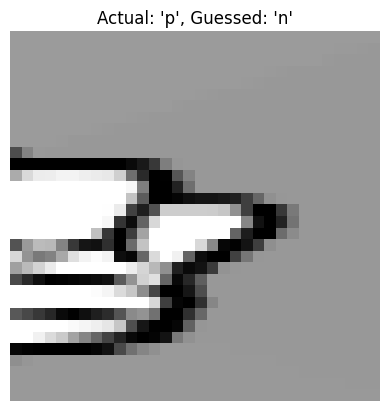

---
	#6207 | Actual: 'B', Guessed: 'K'


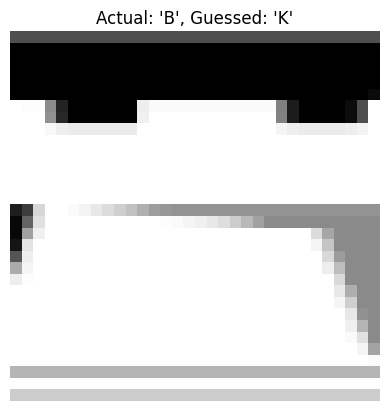

---
	#2500 | Actual: 'k', Guessed: 'Q'


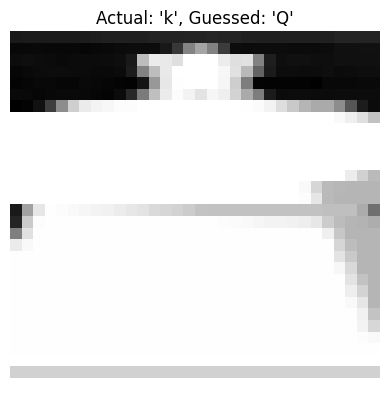

---
	#7156 | Actual: 'p', Guessed: 'r'


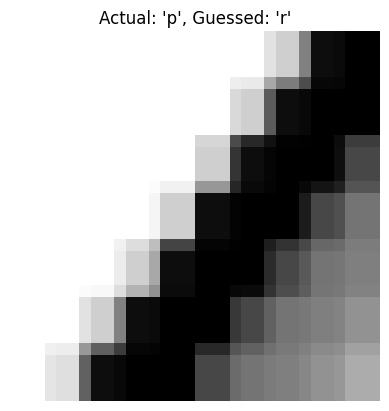

---
	#2292 | Actual: 'P', Guessed: 'B'


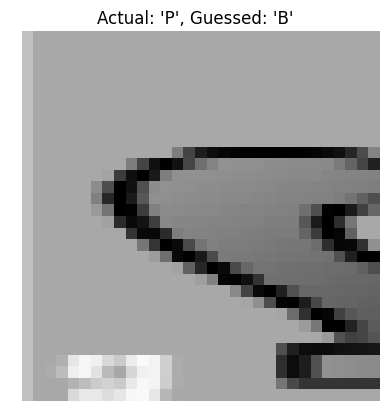

#3578 | Actual: 'r', Guessed: 'r'


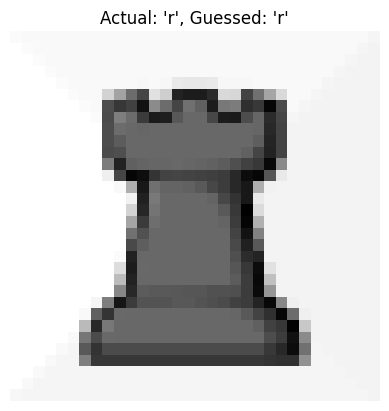

#2280 | Actual: 'Q', Guessed: 'Q'


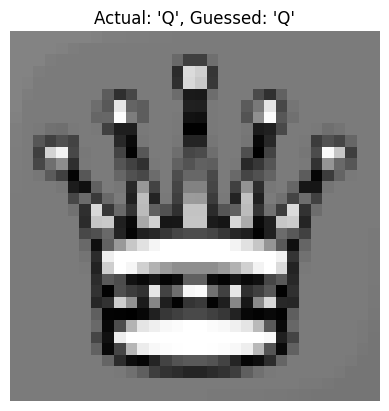

#10795 | Actual: 'n', Guessed: 'n'


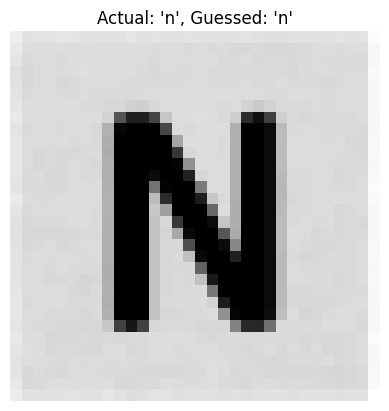

#3199 | Actual: ' ', Guessed: ' '


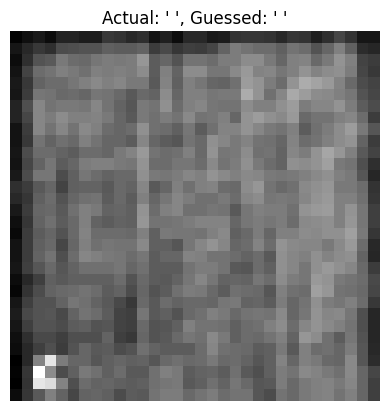

#3241 | Actual: 'n', Guessed: 'n'


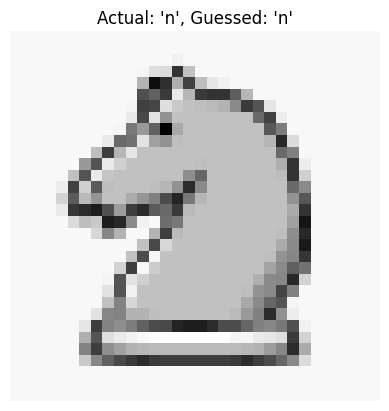

In [ ]:
# Import necessary libraries
import os
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Helper Functions
def getFENtileLabel(fen,letter,number):
  """Given a fen string and a rank (number) and file (letter), return label vector"""
  l2i = lambda l:  ord(l)-ord('A') # letter to index
  number = 8-number # FEN has order backwards
  piece_letter = fen[number*8+number + l2i(letter)]
  label = np.zeros(13, dtype=np.uint8)
  label['1KQRBNPkqrbnp'.find(piece_letter)] = 1 # note the 1 instead of ' ' due to FEN notation
  # We ignore shorter FENs with numbers > 1 because we generate the FENs ourselves
  return label

def labelIndex2Name(label_index):
  """Convert label index into name of piece"""
  return ' KQRBNPkqrbnp'[label_index]

def shortenFEN(fen):
  """Reduce FEN to shortest form (ex. '111p11Q' becomes '3p2Q')"""
  return fen.replace('11111111','8').replace('1111111','7') \
            .replace('111111','6').replace('11111','5') \
            .replace('1111','4').replace('111','3').replace('11','2')

def lengthenFEN(fen):
  """Lengthen FEN to 71-character form (ex. '3p2Q' becomes '111p11Q')"""
  return fen.replace('8','11111111').replace('7','1111111') \
            .replace('6','111111').replace('5','11111') \
            .replace('4','1111').replace('3','111').replace('2','11')

def unflipFEN(fen):
    if len(fen) < 71:
        fen = lengthenFEN(FEN)
    return '/'.join([ r[::-1] for r in fen.split('/') ][::-1])

# Dataset class for PyTorch
class ChessDataset(Dataset):
    def __init__(self, image_filepaths):
        self.image_filepaths = image_filepaths
        self.num_images = len(image_filepaths)
        # Each tile is a 32x32 grayscale image
        self.images = np.zeros([self.num_images, 32, 32], dtype=np.uint8)
        self.labels = np.zeros([self.num_images], dtype=np.int64)  # Store labels as integers

        for i, image_filepath in enumerate(self.image_filepaths):
            if i % 1000 == 0:
                print(".", end='', flush=True)

            # Load Image
            with Image.open(image_filepath) as img:
                img = img.convert('L')  # Ensure image is in grayscale
                self.images[i, :, :] = np.array(img, dtype=np.uint8)

            # Extract FEN, rank, and file from filename
            # Adjust the slicing based on your actual filename structure
            # For example, if filename is "path/to/fen_R3p11Q.png", adjust accordingly
            # Here, it's assumed that FEN is positioned at specific indices
            # Please modify the following lines to match your filename format
            filename = os.path.basename(image_filepath)
            # Example filename format: "fen_A1.png" where 'fen' is the FEN string
            # Adjust the following parsing logic as needed
            fen_section = filename.split('_')[0]  # Adjust based on actual naming
            fen = fen_section  # Ensure FEN is in the correct orientation

            _rank = int(filename.split('_')[1][1])  # e.g., 'A3' -> 3
            _file = filename.split('_')[1][0]  # e.g., 'A3' -> 'A'

            label_one_hot = getFENtileLabel(fen, _file, _rank)
            self.labels[i] = np.argmax(label_one_hot)  # Convert one-hot to class index
        print("Done")

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        image = self.images[idx].astype('float32') / 255.0  # Normalize
        image = np.expand_dims(image, axis=0)  # Add channel dimension
        label = self.labels[idx]
        return torch.tensor(image, dtype=torch.float32), label

# Set NumPy print options for better readability
np.set_printoptions(precision=2, suppress=True)

# Load and prepare the data
# Adjust the path according to your data location
data_path = "tiles/*/*.png"  # @param {type:"string"}
all_paths = np.array(glob.glob(data_path))  # Ensure labels are set correctly

# Verify that the data path contains files
if len(all_paths) == 0:
    print(f"No image files found in the path: {data_path}")
    exit(1)

# Shuffle the paths
np.random.shuffle(all_paths)

# Split the data into training and testing sets (90/10 ratio)
ratio = 0.9  # Training/testing ratio
divider = int(len(all_paths) * ratio)
train_paths = all_paths[:divider]
test_paths = all_paths[divider:]

# Load training dataset
print(f"Loading {len(train_paths)} Training tiles", end='')
train_dataset = ChessDataset(train_paths)

# Load testing dataset
print(f"\nLoading {len(test_paths)} Testing tiles", end='')
test_dataset = ChessDataset(test_paths)
print()

# Create DataLoaders
batch_size = 64 # @param {type:"number"}

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Build the CNN model using PyTorch with weight initialization
print("Setting up CNN...")

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # First Convolutional Layer: 32 features, 5x5 kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        # Second Convolutional Layer: 64 features, 5x5 kernel
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        # Fully connected layer
        self.fc1 = nn.Linear(8 * 8 * 64, 1024)
        self.dropout = nn.Dropout(p=0.5)  # Changed from 0.3 to 0.5
        # Output layer
        self.fc2 = nn.Linear(1024, 13)

        # Initialize weights and biases
        self._initialize_weights()

    def _initialize_weights(self):
        # Initialize weights with truncated normal (approximate with normal and clamp)
        nn.init.trunc_normal_(self.conv1.weight, std=0.1)
        nn.init.constant_(self.conv1.bias, 0.1)

        nn.init.trunc_normal_(self.conv2.weight, std=0.1)
        nn.init.constant_(self.conv2.bias, 0.1)

        nn.init.trunc_normal_(self.fc1.weight, std=0.1)
        nn.init.constant_(self.fc1.bias, 0.1)

        nn.init.trunc_normal_(self.fc2.weight, std=0.1)
        nn.init.constant_(self.fc2.bias, 0.1)

    def forward(self, x):
        # Apply first convolutional layer + ReLU activation
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # First pooling

        # Apply second convolutional layer + ReLU activation
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # Second pooling

        # Flatten the tensor
        x = x.view(-1, 8 * 8 * 64)

        # Fully connected layer + ReLU activation
        x = F.relu(self.fc1(x))

        # Apply dropout
        x = self.dropout(x)

        # Output layer (no activation, as CrossEntropyLoss applies Softmax internally)
        x = self.fc2(x)
        return x

# Instantiate the model
model = CNNModel()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set training parameters
do_training = True  # Set to True to train the model
epochs = 100 # @param {type:"number"}

if do_training:
    # Training loop
    model.train()
    print(f"Starting training for {epochs} epochs...")
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Move inputs and labels to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if (i + 1) % 10 == 0:  # Print every 10 batches
                print(f'Epoch [{epoch +1}/{epochs}], Step [{i +1}/{len(train_loader)}], Loss: {running_loss / 10:.4f}')
                running_loss = 0.0

    print('Finished Training')

    # Save the model checkpoint
    os.makedirs('saved_models', exist_ok=True)
    model_save_path = f'saved_models/model_{epochs}.pth'
    torch.save(model.state_dict(), model_save_path)
    print(f'Model saved in file: {model_save_path}')
else:
    # Load the pre-trained model
    model_name = f'saved_models/model_{epochs}.pth'
    print(f"Loading model '{model_name}'")
    if os.path.exists(model_name):
        model.load_state_dict(torch.load(model_name, map_location=device))
        model.to(device)
        print("Model loaded.")
    else:
        print(f"Model file '{model_name}' not found.")
        exit(1)

# Evaluate the model on the testing dataset
model.eval()  # Set model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f'Accuracy on test set: {test_accuracy * 100:.2f}%\n')

# Identify and display any misclassified images
# Collect all predictions and labels
all_preds = []
all_labels = []
all_inputs = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_inputs.extend(inputs.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_inputs = np.array(all_inputs)

correct_predictions = all_preds == all_labels
mistake_indices = np.where(~correct_predictions)[0]

# Display mistakes
if mistake_indices.size > 0:
    print(f"{mistake_indices.size} mistakes found:")
    for idx in np.random.choice(mistake_indices, min(5, mistake_indices.size), replace=False):
        actual_label = labelIndex2Name(all_labels[idx])
        guessed_label = labelIndex2Name(all_preds[idx])
        print("---")
        print(f"\t#{idx} | Actual: '{actual_label}', Guessed: '{guessed_label}'")
        # Display the misclassified image
        img = all_inputs[idx].reshape(32, 32)
        plt.imshow(img, cmap='gray')
        plt.title(f"Actual: '{actual_label}', Guessed: '{guessed_label}'")
        plt.axis('off')
        plt.show()
else:
    print("No mistakes found.")

# Display several random samples, including successes
sample_indices = np.random.choice(len(all_inputs), 5, replace=False)
for idx in sample_indices:
    actual_label = labelIndex2Name(all_labels[idx])
    predicted_label = labelIndex2Name(all_preds[idx])
    print(f"#{idx} | Actual: '{actual_label}', Guessed: '{predicted_label}'")
    # Display the image
    img = all_inputs[idx].reshape(32, 32)
    plt.imshow(img, cmap='gray')
    plt.title(f"Actual: '{actual_label}', Guessed: '{predicted_label}'")
    plt.axis('off')
    plt.show()